In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

## Config

In [2]:
variant = 6

## Read data

In [3]:
def get_voltage(filename):
  match = re.search(r'[-+]?\d*\.\d+', filename)

  if match:
    return float(match.group())
  else:
    return None

In [4]:
data_dir = 'rawData'

x_time = None
matrix_time = None

voltages = {}

for filename in os.listdir(data_dir):
  file_path = os.path.join(data_dir, filename)

  if not os.path.isfile(file_path):
    continue

  voltage = get_voltage(filename)

  with open(file_path, 'r') as f:
    data = f.read().strip().splitlines()
    data_columns = [line.split(' ') for line in data]
    df = pd.DataFrame(data_columns)
    y = df[variant].to_numpy().astype(float)

    if x_time is None:
      x_time = df[0].to_numpy().astype(float)

    if matrix_time is None:
      matrix_time = y
    else:
      matrix_time = np.vstack((matrix_time, y))

    if not voltage in voltages:
      voltages[voltage] = y
    else:
      voltages[voltage] = np.concatenate((voltages[voltage], y))

x_time.shape, matrix_time.shape

((1024,), (55, 1024))

In [5]:
y_time = matrix_time.mean(axis=0)
y_time.shape

(1024,)

In [6]:
x_voltage = np.array(list(voltages.keys()))
x_voltage.shape

(11,)

In [7]:
y_voltage = np.array([voltages[voltage].mean() for voltage in voltages])
y_voltage.shape

(11,)

## Visualization

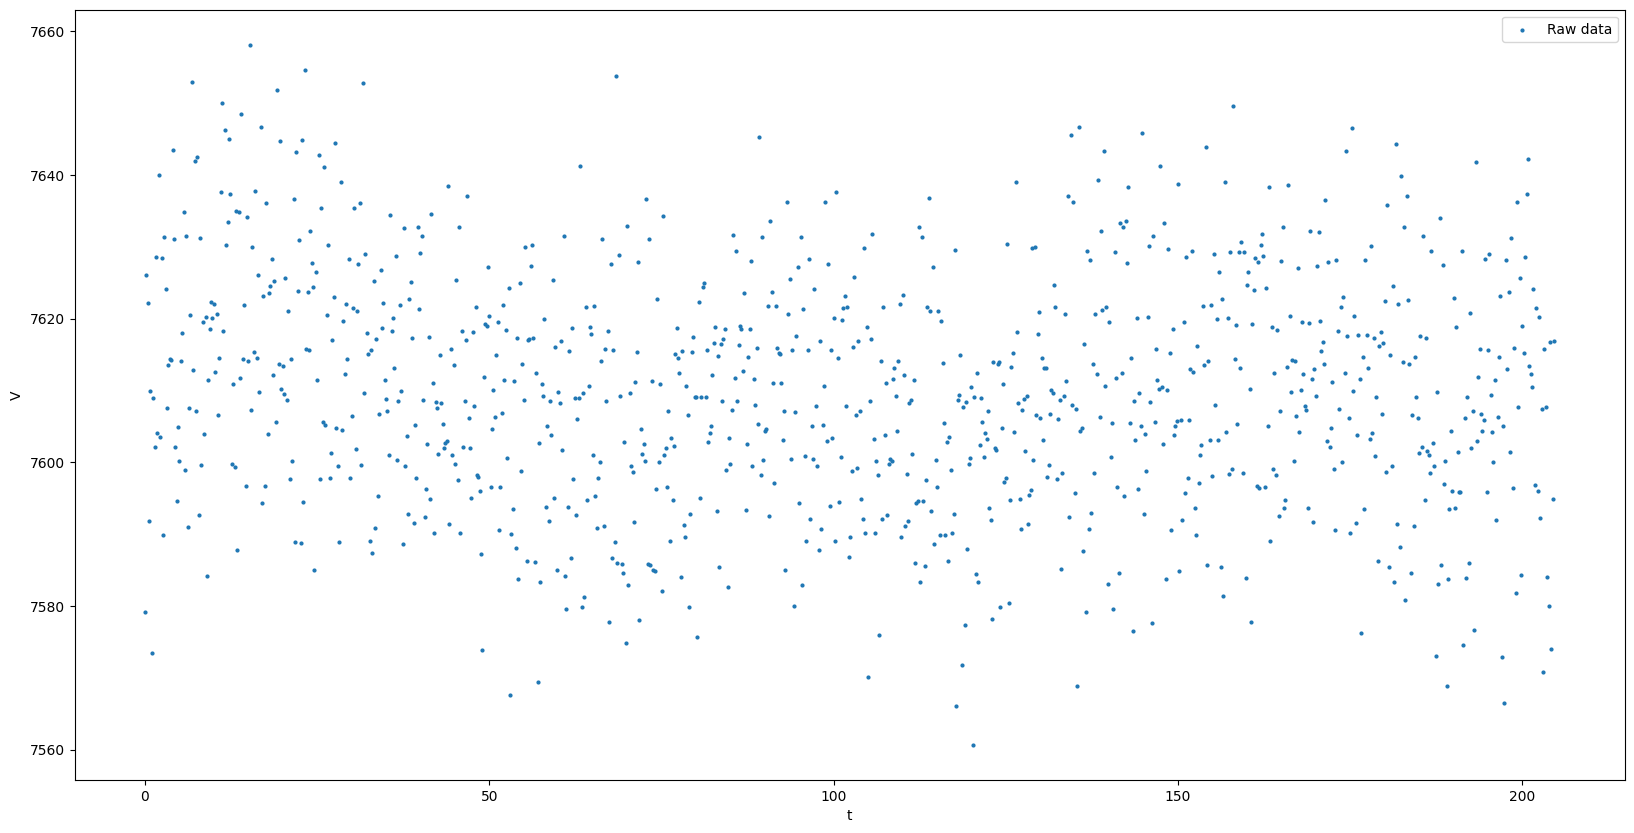

In [8]:
figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_time, y_time, label='Raw data', s=4)
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

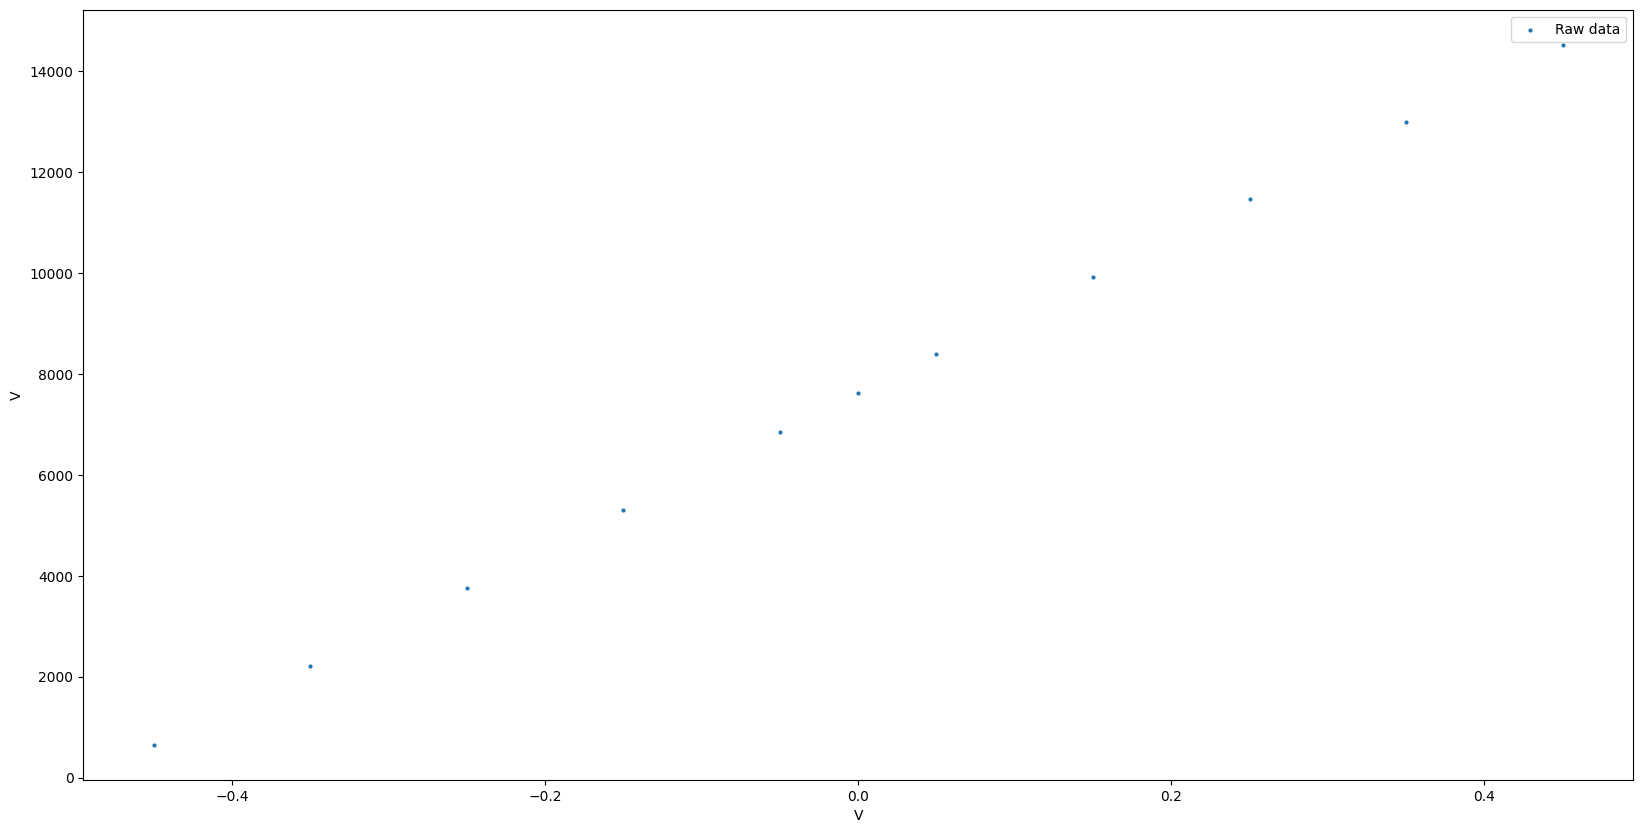

In [9]:
figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage, y_voltage, label='Raw data', s=4)
plt.xlabel('V')
plt.ylabel('V')
plt.legend()

## Linear regression

In [10]:
def lad(params, x, y):
  y_pred = params[0] * x + params[1]
  return np.abs(y - y_pred).mean()

def lsm(params, x, y):
  y_pred = params[0] * x + params[1]
  return ((y - y_pred) ** 2).mean()

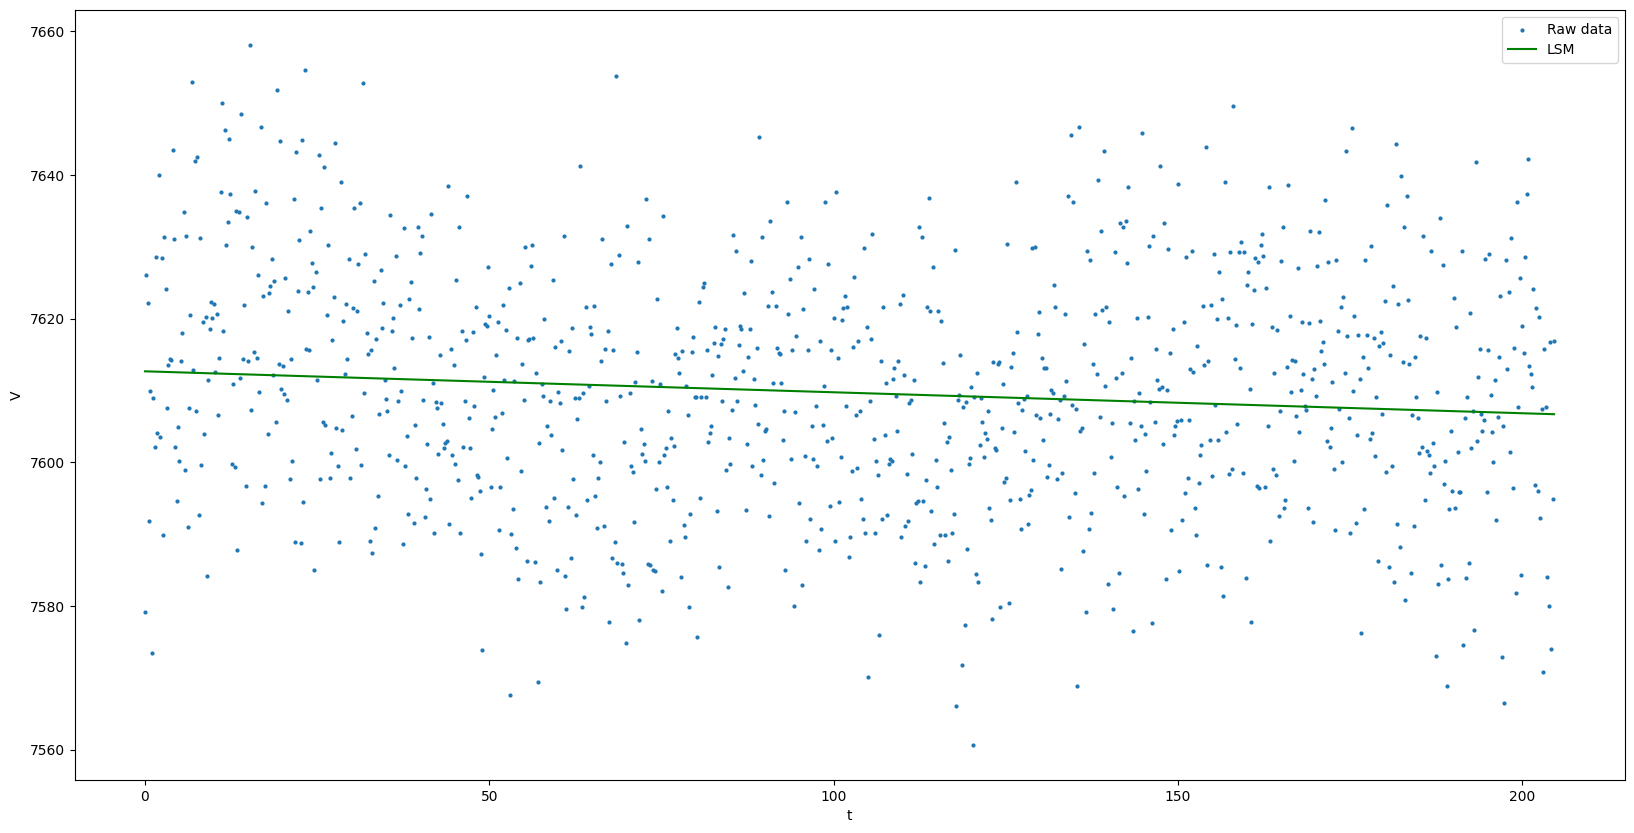

In [11]:
a_sq, b_sq = sp.optimize.minimize(lsm, [0, 0], args=(x_time, y_time)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_time, y_time, label='Raw data', s=4)
plt.plot(x_time, x_time * a_sq + b_sq, color='green', label='LSM')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

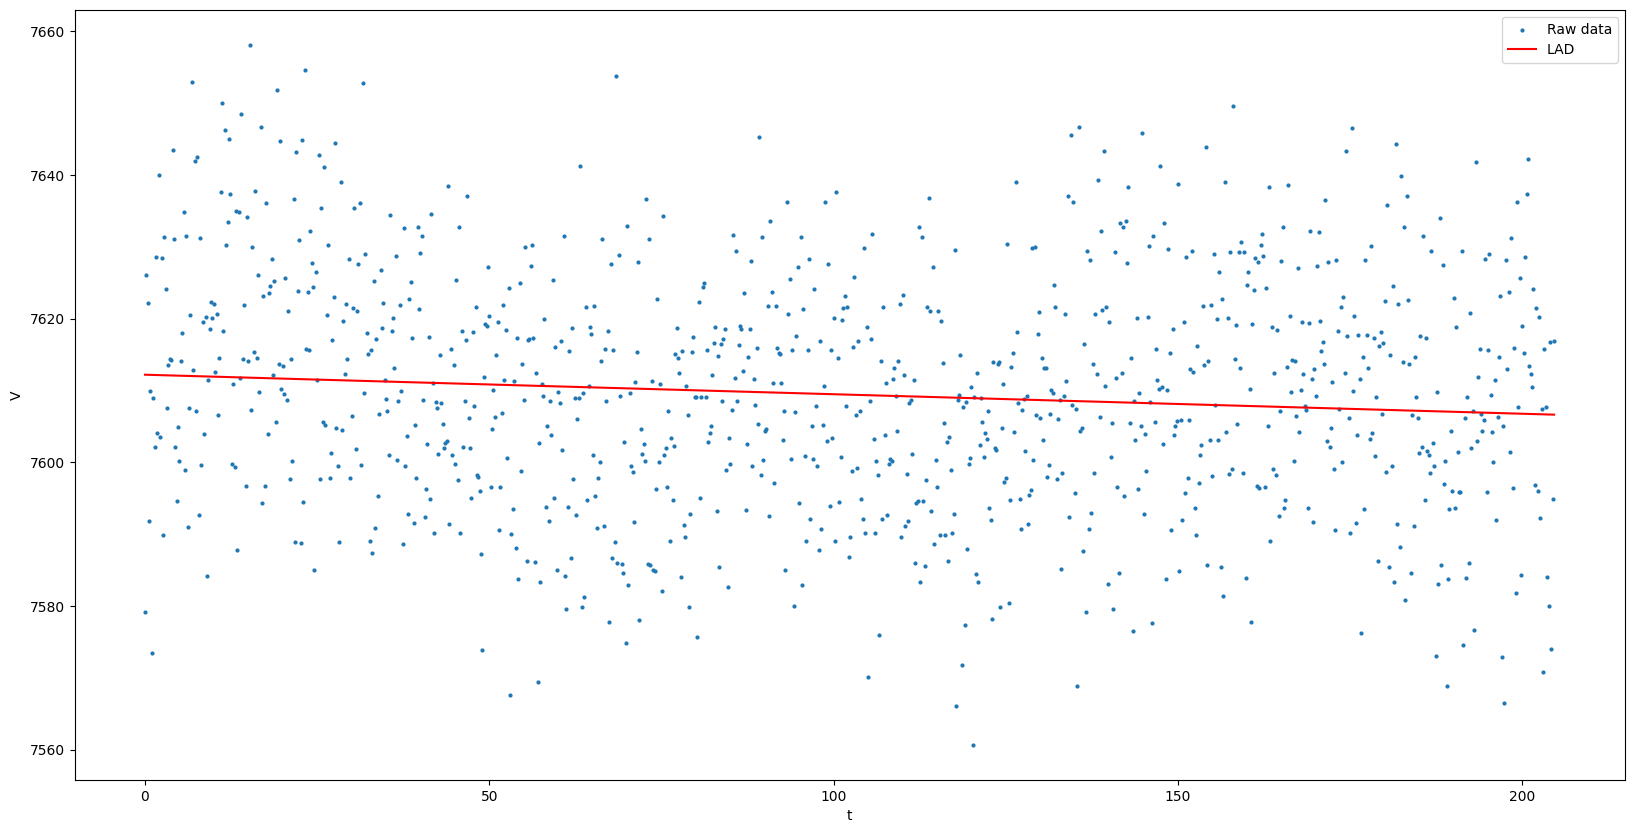

In [12]:
a_abs, b_abs = sp.optimize.minimize(lad, [0, 0], args=(x_time, y_time)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_time, y_time, label='Raw data', s=4)
plt.plot(x_time, x_time * a_abs + b_abs, color='red', label='LAD')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

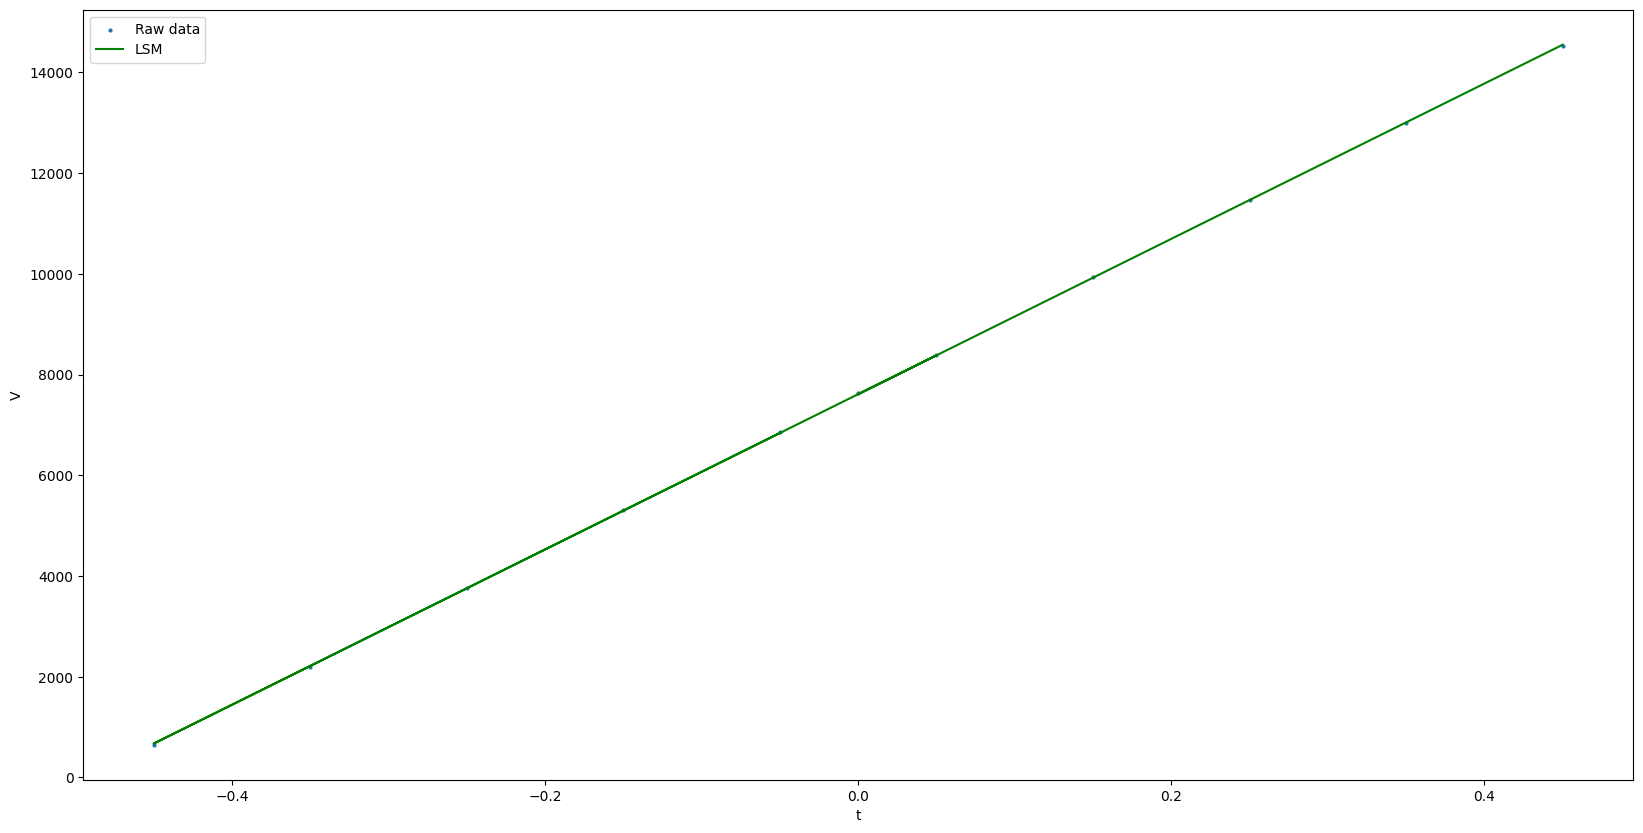

In [13]:
a_sq, b_sq = sp.optimize.minimize(lsm, [0, 0], args=(x_voltage, y_voltage)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage, y_voltage, label='Raw data', s=4)
plt.plot(x_voltage, x_voltage * a_sq + b_sq, color='green', label='LSM')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

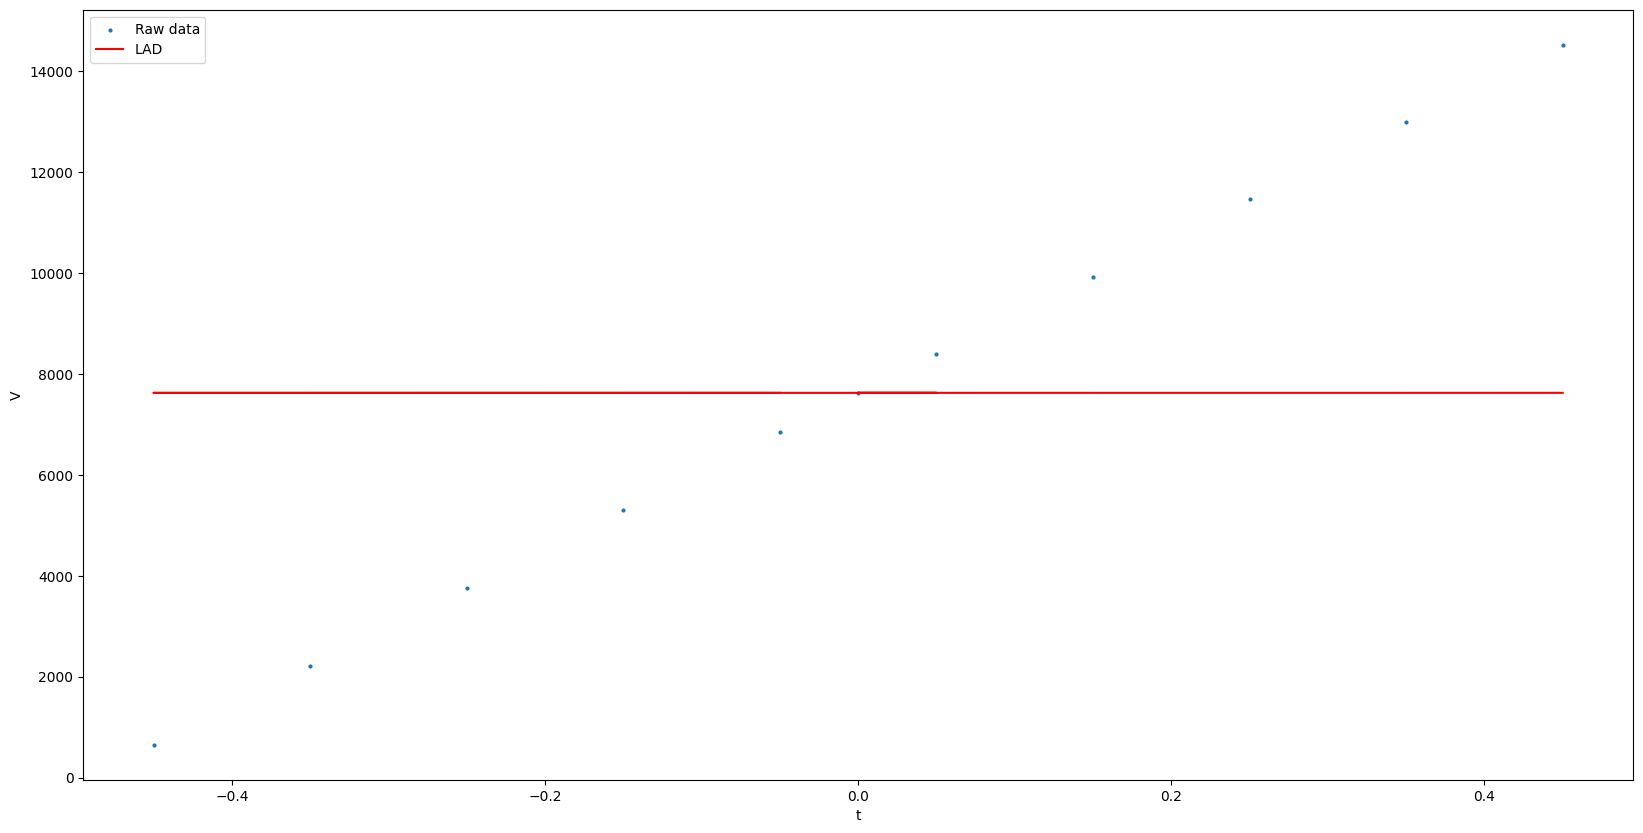

In [14]:
a_abs, b_abs = sp.optimize.minimize(lad, [0, 0], args=(x_voltage, y_voltage)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage, y_voltage, label='Raw data', s=4)
plt.plot(x_voltage, x_voltage * a_abs + b_abs, color='red', label='LAD')
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

In [15]:
a_abs, b_abs, a_sq, b_sq

(0.9435465649243712, 7625.36171874267, 15416.692052379618, 7609.691102883446)

## Non-average

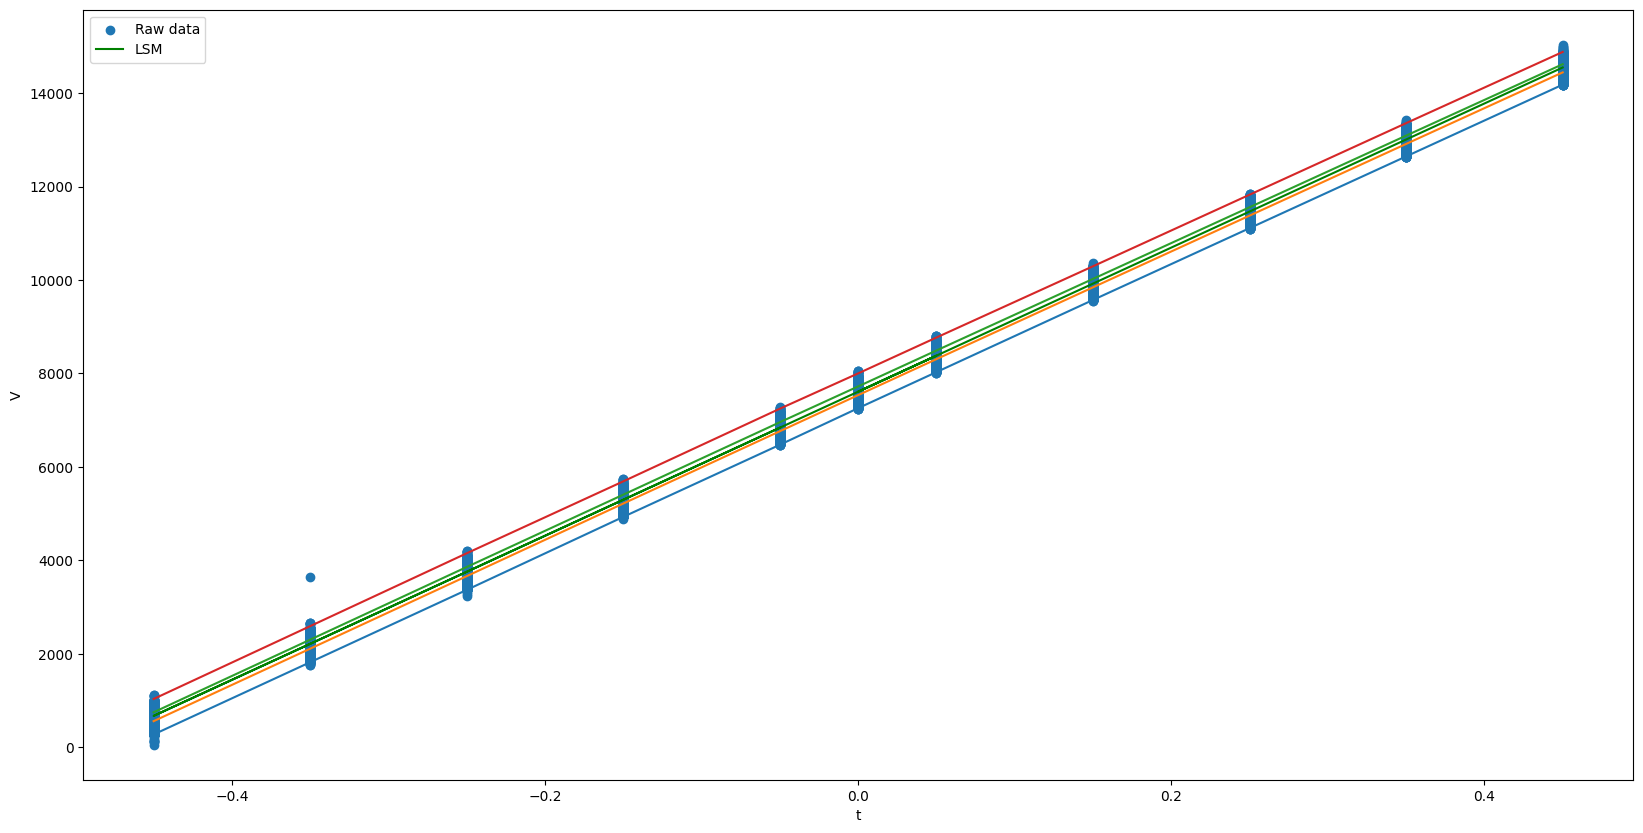

In [63]:
x_voltage_all = np.array([])
y_voltage_all = np.array([])

borders = np.array([])

for voltage, y_voltage_partial in voltages.items():
  if borders.shape == (0,):
    qtls = np.quantile(y_voltage_partial, [0.25, 0.75])
    diff = qtls[1] - qtls[0]
    borders = np.array([qtls[0] - 1.5*diff, qtls[0], qtls[1], qtls[1] + 1.5 * diff])
    # print(borders)
  else:
    qtls = np.quantile(y_voltage_partial, [0.25, 0.75])
    diff = qtls[1] - qtls[0]
    borders = np.vstack([borders, np.array([qtls[0] - 1.5*diff, qtls[0], qtls[1], qtls[1] + 1.5 * diff])])
  x_voltage_partial = np.full(y_voltage_partial.shape, voltage)

  x_voltage_all = np.concatenate((x_voltage_all, x_voltage_partial))
  y_voltage_all = np.concatenate((y_voltage_all, y_voltage_partial))

a_sq, b_sq = sp.optimize.minimize(lsm, [0, 0], args=(x_voltage_all, y_voltage_all)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage_all, y_voltage_all, label='Raw data')
plt.plot(x_voltage, x_voltage * a_sq + b_sq, color='green', label='LSM')
for i in range(4):
  xs = np.array(list(voltages.keys()))
  ys = borders[:, i]
  pairs = np.dstack((xs, ys))[0]
  pairs = pairs[pairs[:, 0].argsort()]
  plt.plot(pairs[:, 0], pairs[:, 1])
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

In [64]:
print("\\hline")
print("$V_{вх}$ & $V_0$ & $V_{0.25}$ & $V_{0.75}$ & $V_{0.25}$ \\\\")
v_inp = list(voltages.keys())
for i in range(borders.shape[0]):
  qtls = borders[i]
  print(f"{v_inp[i]} & {qtls[0]} & {qtls[1]} & {qtls[2]} & {qtls[3]} \\\\")
  print("\\hline")

\hline
$V_{вх}$ & $V_0$ & $V_{0.25}$ & $V_{0.75}$ & $V_{0.25}$ \\
-0.05 & 6473.5 & 6763.0 & 6956.0 & 7245.5 \\
\hline
-0.15 & 4931.0 & 5216.0 & 5406.0 & 5691.0 \\
\hline
-0.25 & 3368.0 & 3662.0 & 3858.0 & 4152.0 \\
\hline
-0.35 & 1820.5 & 2110.0 & 2303.0 & 2592.5 \\
\hline
-0.45 & 274.0 & 559.0 & 749.0 & 1034.0 \\
\hline
0.05 & 8028.5 & 8306.0 & 8491.0 & 8768.5 \\
\hline
0.0 & 7257.0 & 7536.0 & 7722.0 & 8001.0 \\
\hline
0.15 & 9572.375 & 9842.75 & 10023.0 & 10293.375 \\
\hline
0.25 & 11108.5 & 11377.0 & 11556.0 & 11824.5 \\
\hline
0.35 & 12644.0 & 12911.0 & 13089.0 & 13356.0 \\
\hline
0.45 & 14179.5 & 14442.0 & 14617.0 & 14879.5 \\
\hline


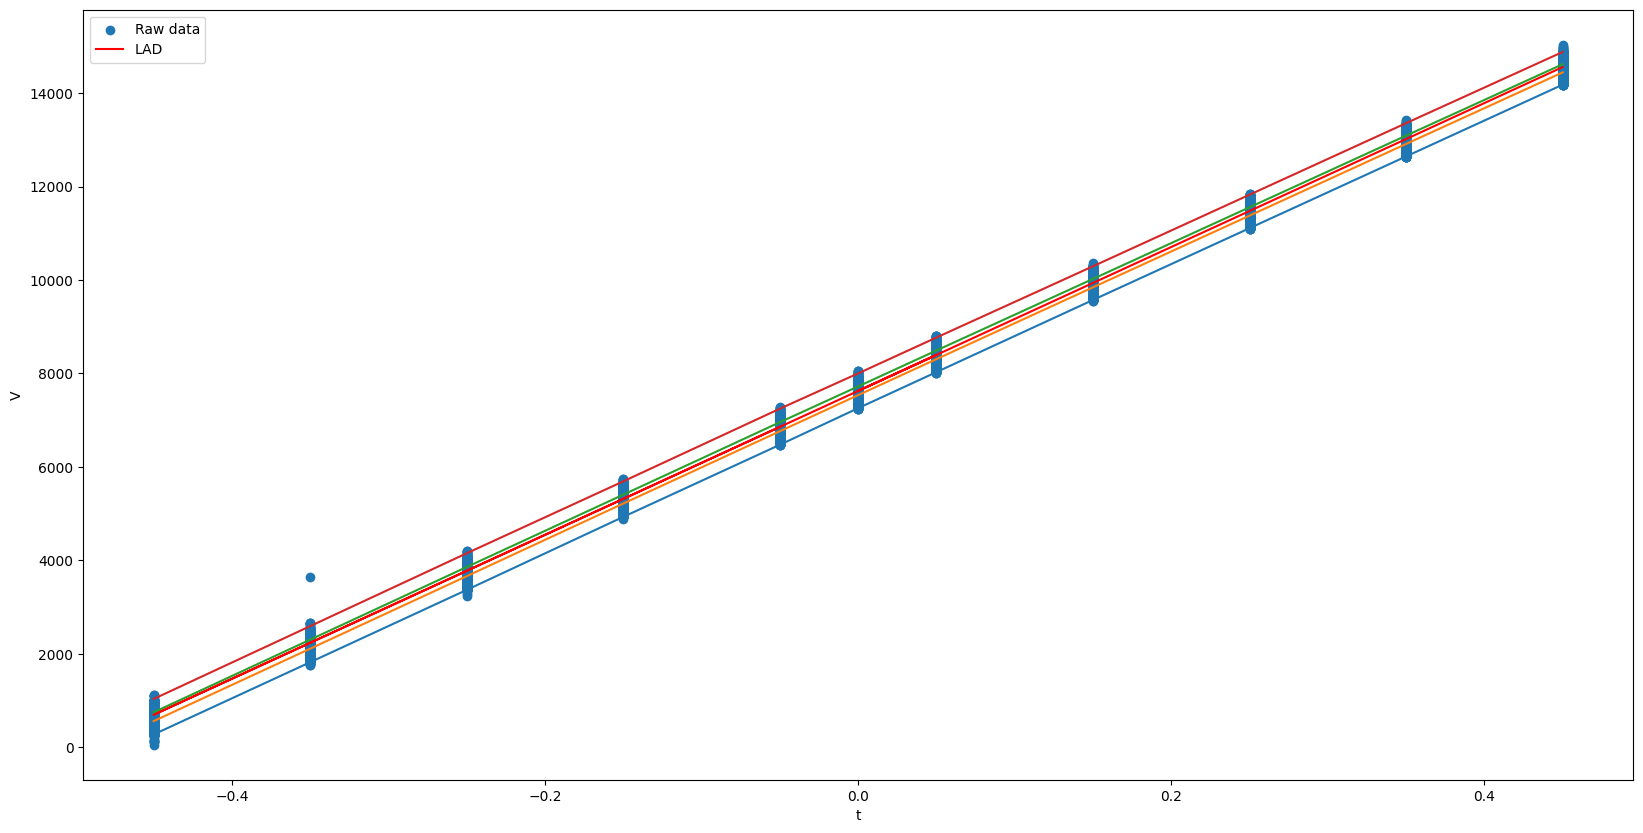

In [65]:
x_voltage_all = np.array([])
y_voltage_all = np.array([])

for voltage, y_voltage_partial in voltages.items():
  x_voltage_partial = np.full(y_voltage_partial.shape, voltage)

  x_voltage_all = np.concatenate((x_voltage_all, x_voltage_partial))
  y_voltage_all = np.concatenate((y_voltage_all, y_voltage_partial))

a_abs, b_abs = sp.optimize.minimize(lad, [0, 0], args=(x_voltage_all, y_voltage_all)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage_all, y_voltage_all, label='Raw data')
plt.plot(x_voltage, x_voltage * a_abs + b_abs, color='red', label='LAD')
for i in range(4):
  xs = np.array(list(voltages.keys()))
  ys = borders[:, i]
  pairs = np.dstack((xs, ys))[0]
  pairs = pairs[pairs[:, 0].argsort()]
  plt.plot(pairs[:, 0], pairs[:, 1])
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

## Boxplot

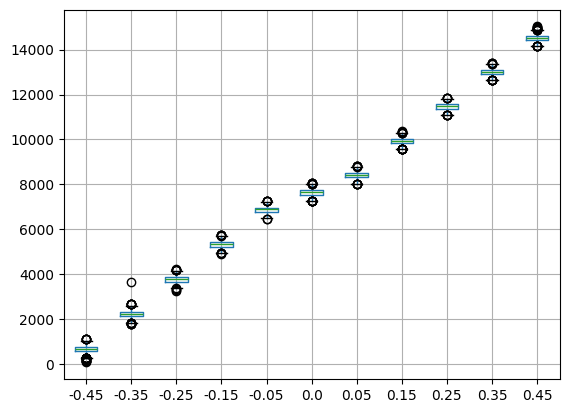

In [66]:
df = pd.DataFrame(voltages, columns=sorted(x_voltage))
boxplot = df.boxplot()

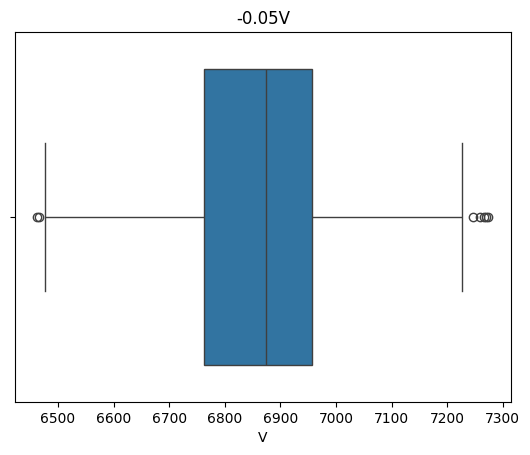

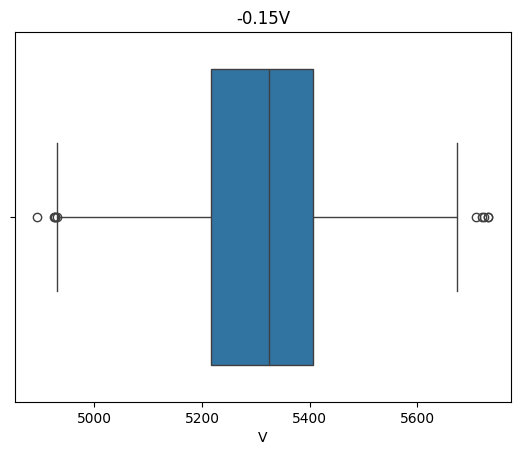

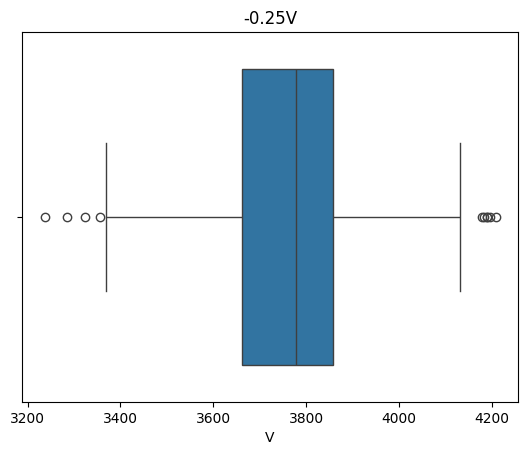

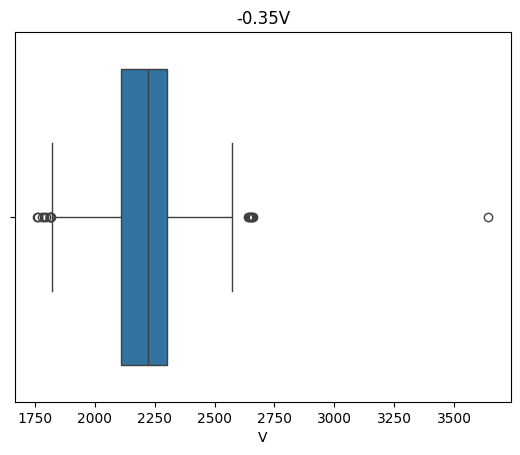

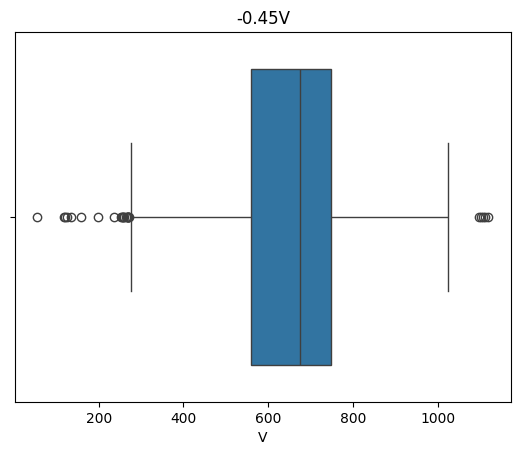

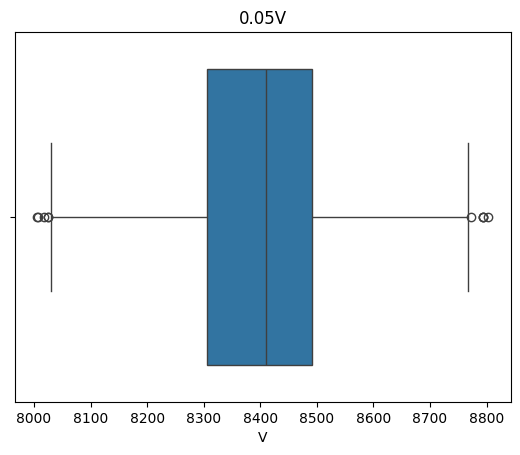

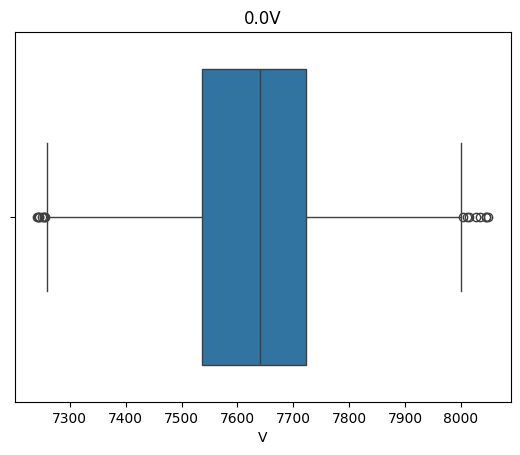

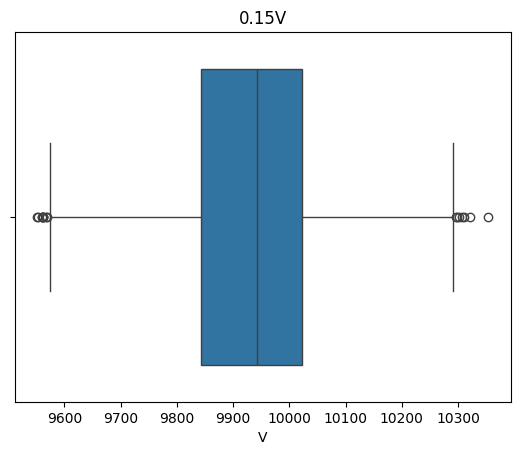

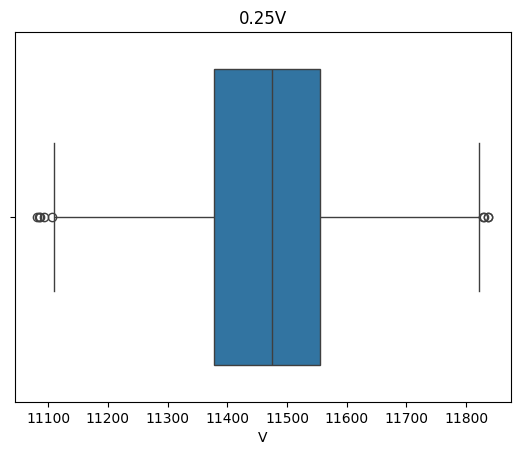

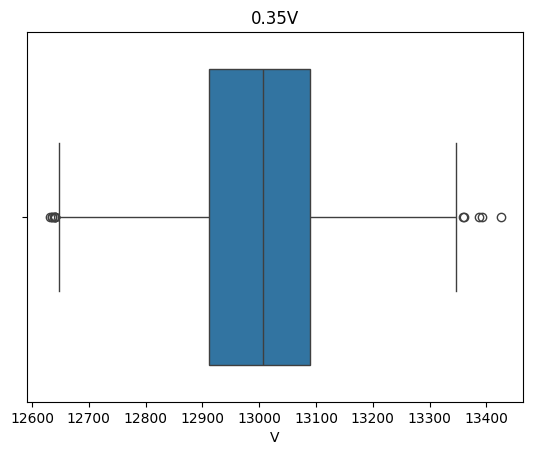

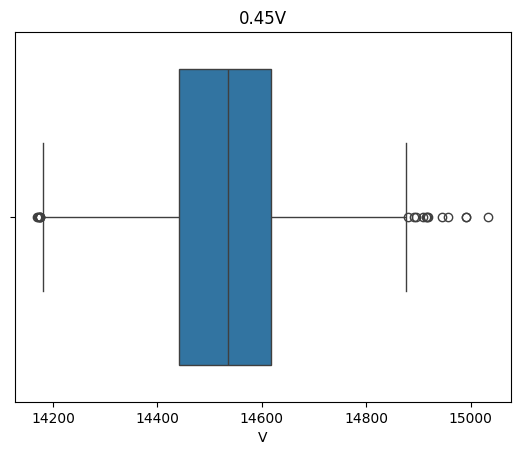

In [67]:
for key, data in voltages.items():
  figure, axis = plt.subplots(1, 1)
  sns.boxplot(x=data, ax=axis)
  axis.set_title(f'{key}V')
  axis.set_xlabel('V')

In [68]:
def filter_out_boxplot(data):
  Q1 = np.percentile(data, 25)
  Q3 = np.percentile(data, 75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  return data[(data >= lower_bound) & (data <= upper_bound)]

In [28]:
x_voltage_all = np.array([])
y_voltage_all = np.array([])

for voltage, y_voltage_partial in voltages.items():
  y_voltage_partial = filter_out_boxplot(y_voltage_partial)
  x_voltage_partial = np.full(y_voltage_partial.shape, voltage)

  x_voltage_all = np.concatenate((x_voltage_all, x_voltage_partial))
  y_voltage_all = np.concatenate((y_voltage_all, y_voltage_partial))

  Q1 = np.percentile(y_voltage_partial, 25)
  Q3 = np.percentile(y_voltage_partial, 75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  print(voltage, IQR, lower_bound, upper_bound)

-0.05 192.0 6475.0 7243.0
-0.45 188.5 277.75 1031.75
-0.35 192.0 1823.0 2591.0
0.35 177.25 12645.875 13354.875
-0.25 195.0 3369.5 4149.5
0.05 184.75 8028.875 8767.875
0.15 179.25 9574.875 10291.875
0.45 174.0 14181.0 14877.0
0.0 185.25 7258.875 7999.875
0.25 179.0 11108.5 11824.5
-0.15 190.0 4931.0 5691.0


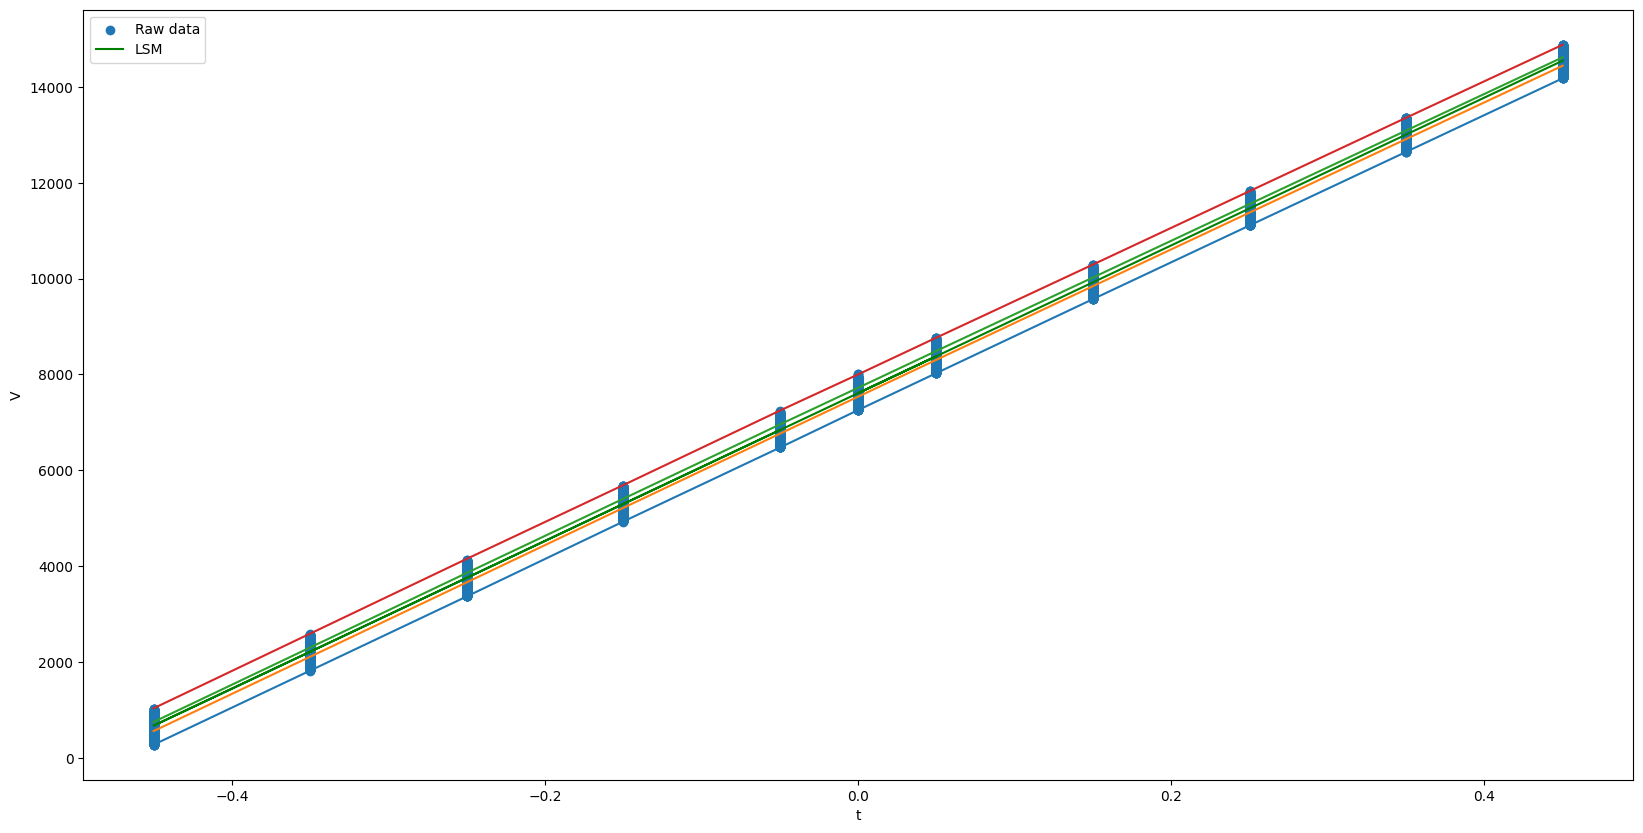

In [70]:
a_sq, b_sq = sp.optimize.minimize(lsm, [0, 0], args=(x_voltage_all, y_voltage_all)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage_all, y_voltage_all, label='Raw data')
plt.plot(x_voltage, x_voltage * a_sq + b_sq, color='green', label='LSM')
for i in range(4):
  xs = np.array(list(voltages.keys()))
  ys = borders[:, i]
  pairs = np.dstack((xs, ys))[0]
  pairs = pairs[pairs[:, 0].argsort()]
  plt.plot(pairs[:, 0], pairs[:, 1])
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

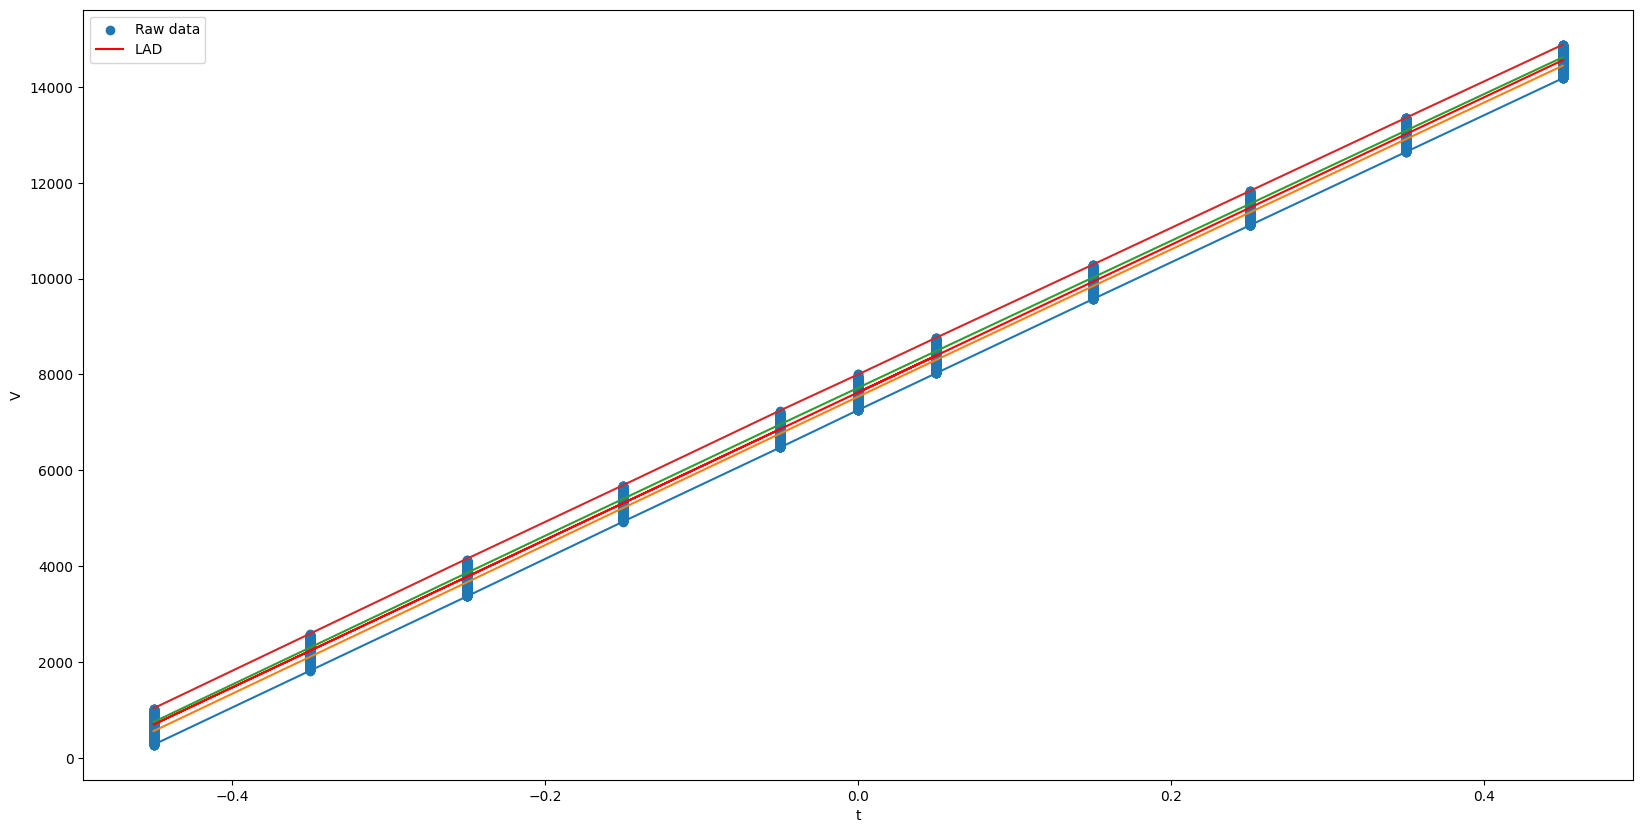

In [71]:
a_abs, b_abs = sp.optimize.minimize(lad, [0, 0], args=(x_voltage_all, y_voltage_all)).x

figure, axis = plt.subplots(1, 1, figsize=(20, 10))
plt.scatter(x_voltage_all, y_voltage_all, label='Raw data')
plt.plot(x_voltage, x_voltage * a_abs + b_abs, color='red', label='LAD')
for i in range(4):
  xs = np.array(list(voltages.keys()))
  ys = borders[:, i]
  pairs = np.dstack((xs, ys))[0]
  pairs = pairs[pairs[:, 0].argsort()]
  plt.plot(pairs[:, 0], pairs[:, 1])
plt.xlabel('t')
plt.ylabel('V')
plt.legend()

In [72]:
a_abs, b_abs, a_sq, b_sq

(15399.999999972546, 7625.99999999651, 15415.877625754985, 7609.739818637322)

## Histogram

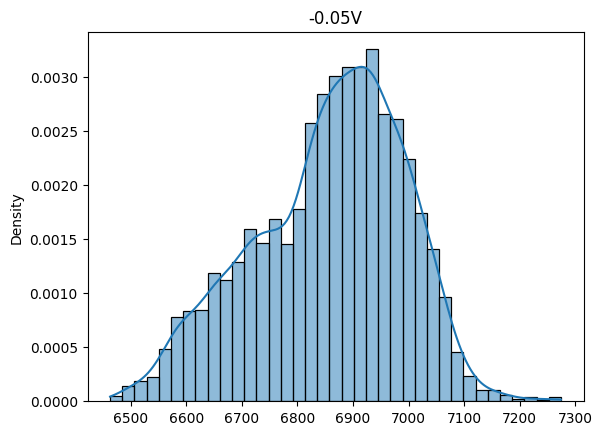

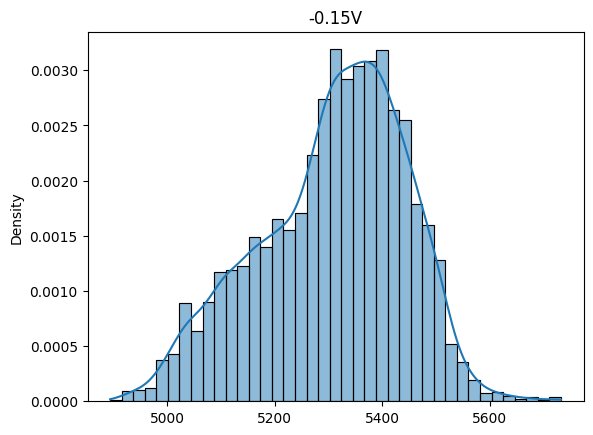

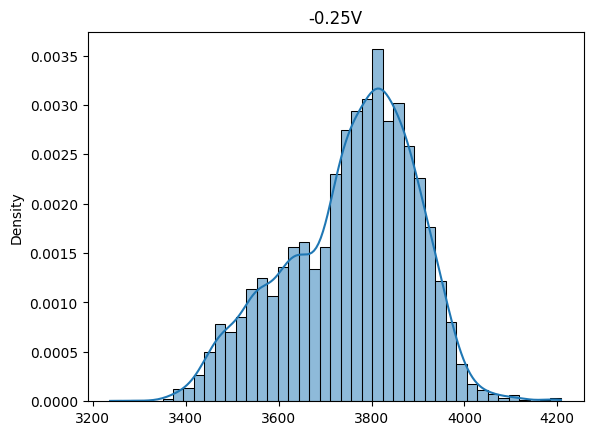

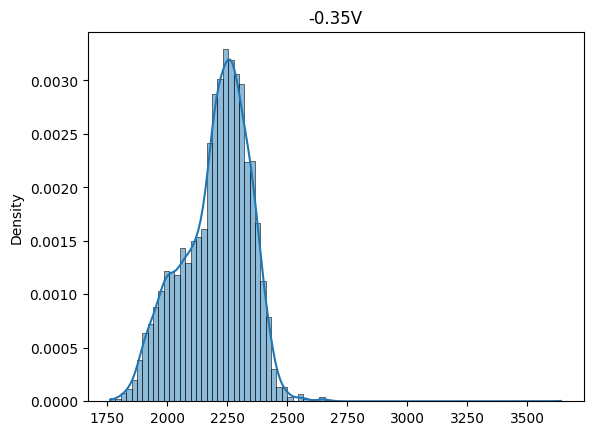

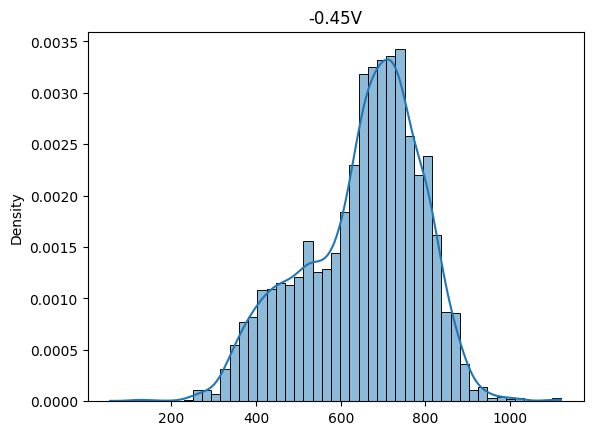

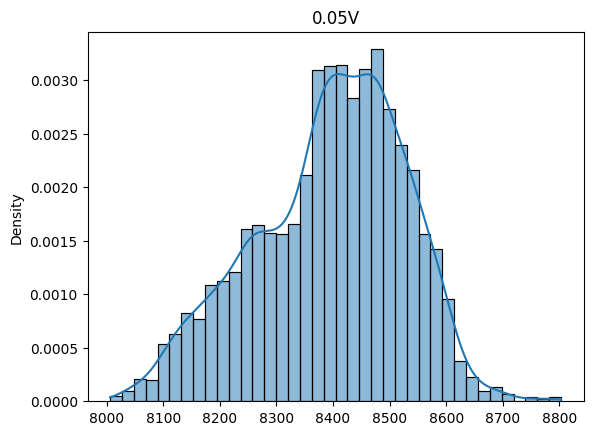

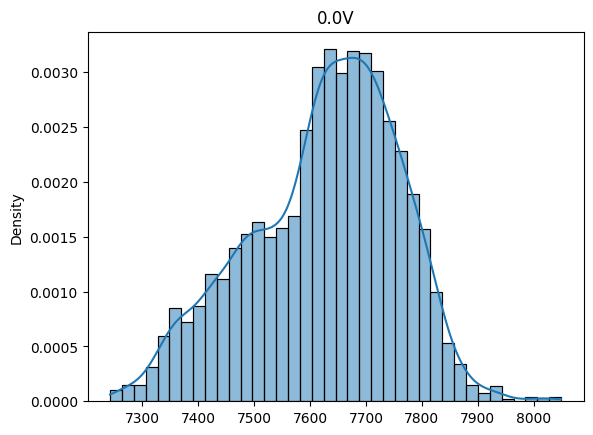

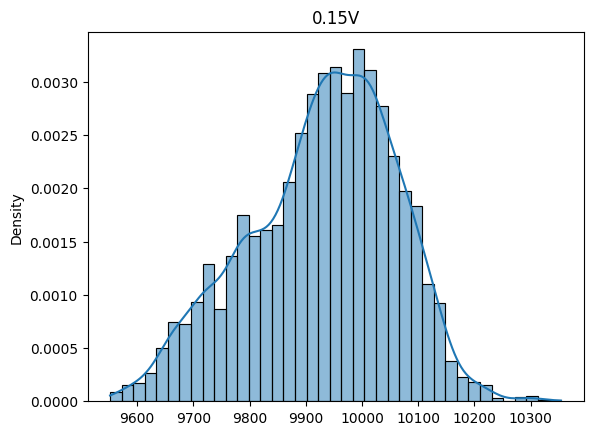

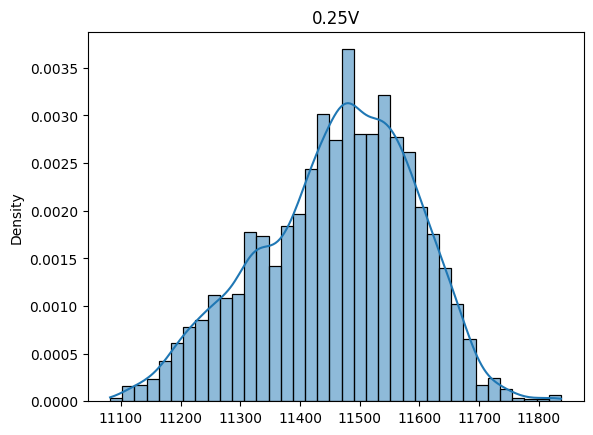

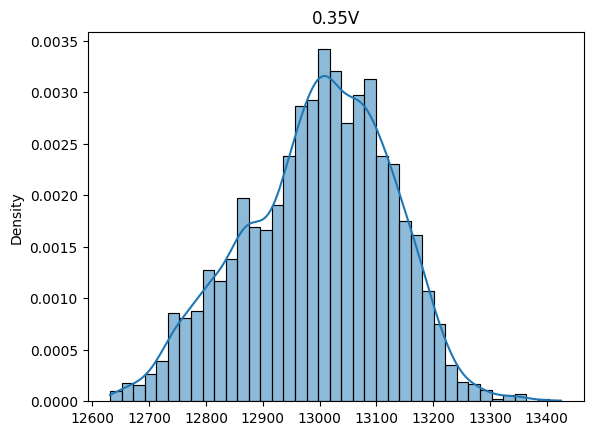

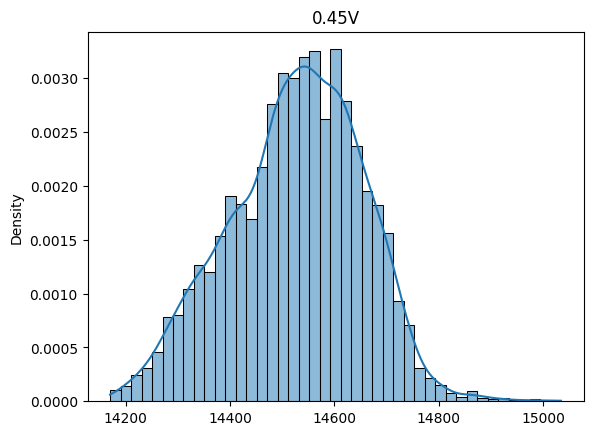

In [73]:
for key, data in voltages.items():
  figure, axis = plt.subplots(1, 1)
  sns.histplot(data, stat='density', kde=True, ax=axis)
  axis.set_title(f'{key}V')

In [74]:
voltages

{-0.05: array([6754., 6684., 6924., ..., 6803., 6877., 6960.]),
 -0.15: array([5226., 5295., 5185., ..., 5322., 5326., 5293.]),
 -0.25: array([3469., 3551., 3708., ..., 3485., 3480., 3609.]),
 -0.35: array([1766., 2419., 2040., ..., 2031., 2045., 2115.]),
 -0.45: array([423., 474., 686., ..., 364., 468., 588.]),
 0.05: array([8392., 8255., 8500., ..., 8482., 8355., 8414.]),
 0.0: array([7590., 7500., 7637., ..., 7699., 7806., 7592.]),
 0.15: array([9974., 9744., 9885., ..., 9893., 9921., 9958.]),
 0.25: array([11580., 11291., 11427., ..., 11621., 11391., 11698.]),
 0.35: array([13060., 13041., 12815., ..., 13190., 13249., 13259.]),
 0.45: array([14661., 14441., 14408., ..., 14915., 14956., 14991.])}